In [19]:
# Install required libraries
!pip install -q dalle-mini
!pip install -q git+https://github.com/patil-suraj/vqgan-jax.git

prompts = [
    "babies running on fiber",
    "babies running on telephone lines",
]

n_predictions = 10

gen_top_k = None
gen_top_p = 700
temperature = .7
cond_scale = 500.0

DALLE_MODEL = "dalle-mini/dalle-mini/mega-1-fp16:latest"  # can be wandb artifact or 🤗 Hub or local folder or google bucket
DALLE_COMMIT_ID = None
VQGAN_REPO = "dalle-mini/vqgan_imagenet_f16_16384"
VQGAN_COMMIT_ID = "e93a26e7707683d349bf5d5c41c5b0ef69b677a9"

import jax
import jax.numpy as jnp
from functools import partial

@partial(jax.pmap, axis_name="batch", static_broadcasted_argnums=(3, 4, 5, 6))
def p_generate(
    tokenized_prompt, key, params, top_k, top_p, temperature, condition_scale
):
    return model.generate(
        **tokenized_prompt,
        prng_key=key,
        params=params,
        top_k=top_k,
        top_p=top_p,
        temperature=temperature,
        condition_scale=condition_scale,
    )

# decode image
@partial(jax.pmap, axis_name="batch")
def p_decode(indices, params):
    return vqgan.decode_code(indices, params=params)
import random

from dalle_mini import DalleBart, DalleBartProcessor
from vqgan_jax.modeling_flax_vqgan import VQModel

# Load dalle-mini
model, params = DalleBart.from_pretrained(
    DALLE_MODEL, revision=DALLE_COMMIT_ID, dtype=jnp.float16, _do_init=False
)

# Load VQGAN
vqgan, vqgan_params = VQModel.from_pretrained(
    VQGAN_REPO, revision=VQGAN_COMMIT_ID, _do_init=False
)
from flax.jax_utils import replicate

params = replicate(params)
vqgan_params = replicate(vqgan_params)
from functools import partial

# create a random key
seed = random.randint(0, 2**32 - 1)
key = jax.random.PRNGKey(seed)
from dalle_mini import DalleBartProcessor

processor = DalleBartProcessor.from_pretrained(DALLE_MODEL, revision=DALLE_COMMIT_ID)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


wandb: Downloading large artifact mega-1-fp16:latest, 4938.53MB. 7 files... Done. 0:0:3.4
Some of the weights of DalleBart were initialized in float16 precision from the model checkpoint at /tmp/tmp5hz_emv0:
[('lm_head', 'kernel'), ('model', 'decoder', 'embed_positions', 'embedding'), ('model', 'decoder', 'embed_tokens', 'embedding'), ('model', 'decoder', 'final_ln', 'bias'), ('model', 'decoder', 'layernorm_embedding', 'bias'), ('model', 'decoder', 'layernorm_embedding', 'scale'), ('model', 'decoder', 'layers', 'FlaxBartDecoderLayers', 'FlaxBartAttention_0', 'k_proj', 'kernel'), ('model', 'decoder', 'layers', 'FlaxBartDecoderLayers', 'FlaxBartAttention_0', 'out_proj', 'kernel'), ('model', 'decoder', 'layers', 'FlaxBartDecoderLayers', 'FlaxBartAttention_0', 'q_proj', 'kernel'), ('model', 'decoder', 'layers', 'FlaxBartDecoderLayers', 'FlaxBartAttention_0', 'v_proj', 'kernel'), ('model', 'decoder', 'layers', 'FlaxBartDecoderLayers', 'FlaxBartAttention_1', 'k_proj', 'kernel'), ('model', 'd

Prompts: ['babies running on fiber', 'babies running on telephone lines']



  0%|          | 0/10 [00:00<?, ?it/s]

0: babies running on fiber


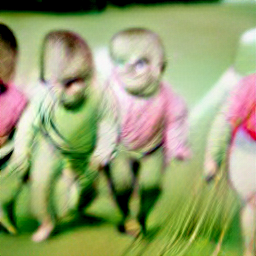

1: babies running on telephone lines


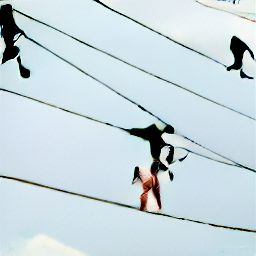

0: babies running on fiber


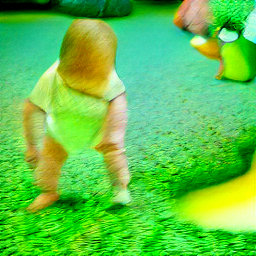

1: babies running on telephone lines


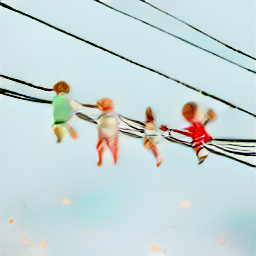

0: babies running on fiber


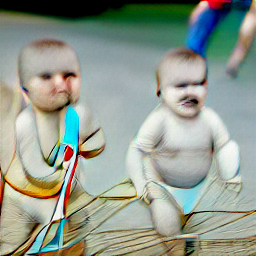

1: babies running on telephone lines


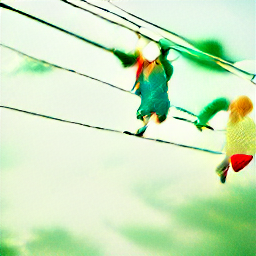

0: babies running on fiber


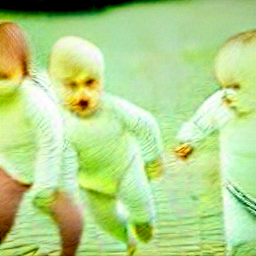

1: babies running on telephone lines


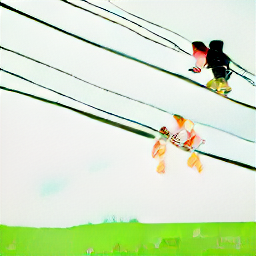

0: babies running on fiber


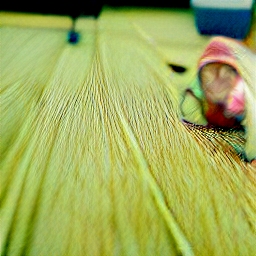

1: babies running on telephone lines


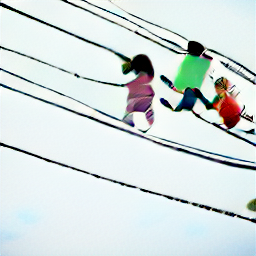

0: babies running on fiber


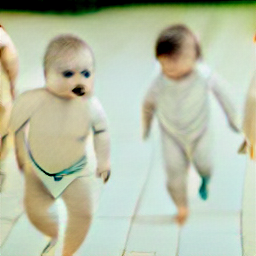

1: babies running on telephone lines


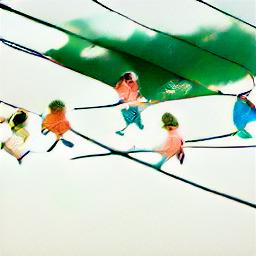

0: babies running on fiber


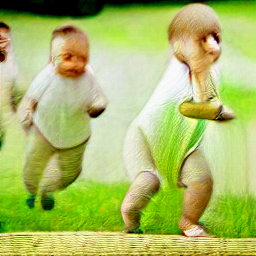

1: babies running on telephone lines


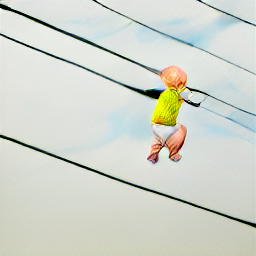

0: babies running on fiber


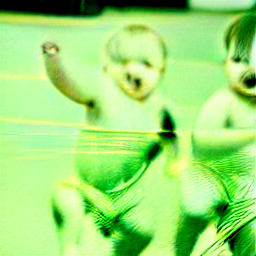

1: babies running on telephone lines


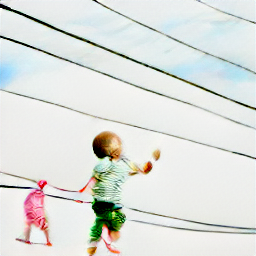

0: babies running on fiber


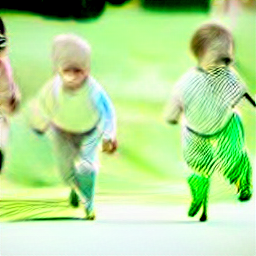

1: babies running on telephone lines


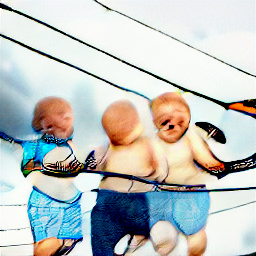

0: babies running on fiber


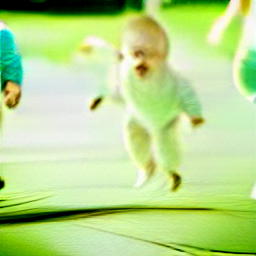

1: babies running on telephone lines


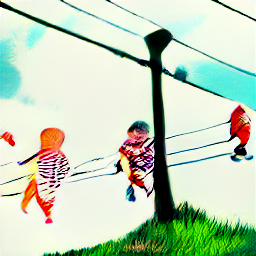

In [20]:
tokenized_prompts = processor(prompts)
tokenized_prompt = replicate(tokenized_prompts)

from IPython.core.display_functions import display
from flax.training.common_utils import shard_prng_key
import numpy as np
from PIL import Image
from tqdm.notebook import trange

print(f"Prompts: {prompts}\n")
# generate images
images = []
for i in trange(max(n_predictions // jax.device_count(), 1)):
    # get a new key
    key, subkey = jax.random.split(key)
    # generate images
    encoded_images = p_generate(
        tokenized_prompt,
        shard_prng_key(subkey),
        params,
        gen_top_k,
        gen_top_p,
        temperature,
        cond_scale,
    )
    # remove BOS
    encoded_images = encoded_images.sequences[..., 1:]
    # decode images
    decoded_images = p_decode(encoded_images, vqgan_params)
    decoded_images = decoded_images.clip(0.0, 1.0).reshape((-1, 256, 256, 3))
    for j, decoded_img in enumerate(decoded_images):
        img = Image.fromarray(np.asarray(decoded_img * 255, dtype=np.uint8))
        images.append(img)
        print(f"{i}: {prompts[j]}")
        display(img)


In [21]:
Click on the link above to check out your generated images.
